In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib_venn import venn2, venn3
import os
from IPython.display import Image

In [2]:
# Global options

sns.set_style("white")
sns.set(font_scale=2, style="ticks")

height=15
aspect=1
x_jitter=0
y_jitter=0

xlim=(0,10)
ylim=(-10, 10)
alpha=1
marker='.'
s=1
legend=True
legend_out=False
linewidth=0
x_jitter=0
y_jitter=0
plt.rcParams["figure.figsize"] = (20,20)

In [3]:
def merge_intervals(input_list):
    """
    Given a list of intervals, merge the overlapping ones.
    https://stackoverflow.com/questions/43600878/merging-overlapping-intervals
    """
    # sort interval
    input_list.sort(key=lambda interval: interval[0])
    merged = [input_list[0]]
    for current in input_list:
        previous = merged[-1]
        if current[0] <= previous[1]:
            previous[1] = max(previous[1], current[1])
        else:
            merged.append(current)
    return merged

In [4]:
def counts2tpm(df_short):
    
    df_short = df_short[df_short.iloc[:,2:].sum(axis=1)>10]

    # add pseudocount
    df_short.iloc[:,2:] = df_short.iloc[:,2:] + 1
    
    sample_reads = df_short.iloc[:,2:].copy()
    gene_len = df_short.loc[:, ['length']]
    rate = sample_reads.values / gene_len.values
    tpm = pd.DataFrame(rate / np.sum(rate, axis=0).reshape(1, -1) * 1e6, columns=df_short.columns[2:], index=df_short.Name)
    
    tpm = np.log2(tpm)
    
    return tpm

In [5]:
annotation_path = "../../00_annotation/results/annotation/canonical_geneset.exons.no_repeat_overlap_and_ce_11_repeats.filtered.merged.gtf"

In [6]:
annotation = pd.read_csv(annotation_path, header=None, sep="\t")
annotation.columns = ["seqname",
                      "source",
                      "feature",
                      "start",
                      "end",
                      "score",
                      "strand",
                      "frame",
                      "attribute"]

In [7]:
annotation = annotation[annotation["feature"] == "exon"]

In [8]:
annotation.head()

seqname    source feature  start  end score strand frame  \
0   MtDNA  WormBase    exon      1   55     .      +     .   
1   MtDNA  WormBase    exon     58  111     .      +     .   
2   MtDNA  WormBase    exon    113  549     .      +     .   
3   MtDNA  WormBase    exon    549  783     .      +     .   
4   MtDNA  WormBase    exon    785  840     .      +     .   

                                           attribute  
0  gene_id "WBGene00014450"; transcript_id "MTCE....  
1  gene_id "WBGene00014451"; transcript_id "MTCE....  
2  gene_id "WBGene00010957"; transcript_id "MTCE....  
3  gene_id "WBGene00010958"; transcript_id "MTCE....  
4  gene_id "WBGene00014452"; transcript_id "MTCE....

In [9]:
annotation["gene_id"] = annotation["attribute"].str.split(";").str[0].str.replace("gene_id ", "").str.replace("\"", "")

In [10]:
annotation_short = annotation[["seqname", "start", "end", "score", "gene_id", "strand"]].copy()

In [11]:
annotation_short.head()

seqname  start  end score         gene_id strand
0   MtDNA      1   55     .  WBGene00014450      +
1   MtDNA     58  111     .  WBGene00014451      +
2   MtDNA    113  549     .  WBGene00010957      +
3   MtDNA    549  783     .  WBGene00010958      +
4   MtDNA    785  840     .  WBGene00014452      +

In [12]:
annotation_short["start"] = annotation_short["start"] - 1

In [13]:
annotation_short.head()

seqname  start  end score         gene_id strand
0   MtDNA      0   55     .  WBGene00014450      +
1   MtDNA     57  111     .  WBGene00014451      +
2   MtDNA    112  549     .  WBGene00010957      +
3   MtDNA    548  783     .  WBGene00010958      +
4   MtDNA    784  840     .  WBGene00014452      +

In [14]:
w = open("union_exons.bed", 'w')
for gene_group in annotation_short.groupby("gene_id"):
    seqname, score, gene_id, strand = gene_group[1].iloc[0][["seqname", "score", "gene_id", "strand"]]
    intervals = merge_intervals(gene_group[1][(["start", "end"])].values.tolist())
    for interval in intervals:
        w.write("\t".join([str(seqname), str(interval[0]), str(interval[1]), str(score), gene_id, strand + os.linesep]))
w.close()

In [15]:
union_bed = pd.read_csv("union_exons.bed", header=None, sep="\t")
union_bed.columns = ["chrom", "start", "end", "score", "gene_id", "strand"]
union_bed["length"] = union_bed["end"] - union_bed["start"]

In [16]:
gene_length = union_bed.groupby("gene_id")["length"].sum().reset_index()
gene_length.columns = ["Name", "length"]

In [17]:
gene_length.head()

Name  length
0  I:10005952-10006427:+     476
1  I:10006437-10006683:+     247
2    I:1001335-1001573:-     239
3  I:10015772-10015842:+      71
4    I:1002040-1002265:-     226

In [18]:
gene_length.shape

(101577, 2)

In [19]:
counts_first_experiment = pd.read_csv("../../03_WAGO_IPs/results/counts/1_alignment_per_read_reverse/counts.tsv",
                                      header=0,
                                      sep="\t")

In [20]:
counts_first_experiment.tail(20)

Name  counts_Input_WAGO-1_A  counts_Input_WAGO-1_B  \
75378     X:9937401-9937524:+                      0                      0   
75379     X:9943904-9943944:-                      0                      0   
75380     X:9943954-9944146:-                      0                      0   
75381     X:9944150-9944215:-                      0                      0   
75382       X:994452-994630:-                      0                      0   
75383     X:9966184-9966294:-                      0                      0   
75384          X:9977-10127:-                      0                      0   
75385       X:997892-998053:+                      0                      0   
75386     X:9980373-9980756:+                      0                      0   
75387     X:9980791-9980873:+                      0                      0   
75388     X:9983318-9983731:+                      0                      0   
75389     X:9983641-9983742:-                      0                      0   
75390     X:9986819-9986882:-                      0                      0   
75391       X:999444-999513:+                      0                      0   
75392     X:9994528-9994693:+                      0                      0   
75393            __no_feature                 689087                1346741   
75394             __ambiguous                    560                   1257   
75395         __too_low_aQual                      0                      0   
75396           __not_aligned                      0                      0   
75397  __alignment_not_unique                      0                      0   

       counts_Input_WAGO-1_C  counts_Input_WAGO-1_dpf-3_null_A  \
75378                      0                                 0   
75379                      0                                 0   
75380                      0                                 0   
75381                      0                                 0   
75382                      0                                 0   
75383                      0                                 0   
75384                      0                                 0   
75385                      0                                 0   
75386                      0                                 0   
75387                      0                                 0   
75388                      0                                 0   
75389                      0                                 0   
75390                      0                                 0   
75391                      0                                 0   
75392                      1                                 0   
75393                 875613                            541705   
75394                    853                               240   
75395                      0                                 0   
75396                      0                                 0   
75397                      0                                 0   

       counts_Input_WAGO-1_dpf-3_null_B  counts_Input_WAGO-1_dpf-3_null_C  \
75378                                 0                                 0   
75379                                 0                                 0   
75380                                 0                                 0   
75381                                 0                                 0   
75382                                 0                                 0   
75383                                 0                                 0   
75384                                 0                                 0   
75385                                 0                                 0   
75386                                 0                                 0   
75387                                 0                                 0   
75388                                 0                                 0   
75389                                 0               

In [21]:
counts_first_experiment.shape

(75398, 43)

In [22]:
counts_second_experiment =  pd.read_csv("../../04_csr1_ip_and_wago_double_mutants/results/counts/1_alignment_per_read_reverse/counts.tsv",
                                        header=0,
                                        sep="\t")

In [23]:
counts_second_experiment.shape

(75398, 31)

In [24]:
df = pd.merge(pd.merge(gene_length, counts_first_experiment, on="Name"), counts_second_experiment, on="Name")

In [25]:
df.shape

(75393, 74)

In [26]:
df.tail()

Name  length  counts_Input_WAGO-1_A_x  \
75388  X:9983318-9983731:+     414                        0   
75389  X:9983641-9983742:-     102                        0   
75390  X:9986819-9986882:-      64                        0   
75391    X:999444-999513:+      70                        0   
75392  X:9994528-9994693:+     166                        0   

       counts_Input_WAGO-1_B_x  counts_Input_WAGO-1_C_x  \
75388                        0                        0   
75389                        0                        0   
75390                        0                        0   
75391                        0                        0   
75392                        0                        1   

       counts_Input_WAGO-1_dpf-3_null_A  counts_Input_WAGO-1_dpf-3_null_B  \
75388                                 0                                 0   
75389                                 0                                 0   
75390                                 0                                 0   
75391                                 0                                 0   
75392                                 0                                 0   

       counts_Input_WAGO-1_dpf-3_null_C  counts_Input_WAGO-1_P3G_A  \
75388                                 0                          0   
75389                                 0                          0   
75390                                 0                          0   
75391                                 0                          0   
75392                                 0                          0   

       counts_Input_WAGO-1_P3G_B  ...  counts_HW3134_Replicate_C_IP  \
75388                          0  ...                             0   
75389                          0  ...                             0   
75390                          0  ...                             0   
75391                          0  ...                             1   
75392                          0  ...                             4   

       counts_HW3135_Replicate_A_IP  counts_HW3135_Replicate_B_IP  \
75388                             0                             0   
75389                             0                             0   
75390                             0                             0   
75391                             3                             0   
75392                             1                             1   

       counts_HW3135_Replicate_C_IP  counts_Input_WAGO-1_A_y  \
75388                             0                        0   
75389                             1                        0   
75390                             0                        0   
75391                             0                        0   
75392                             3                        0   

       counts_Input_WAGO-1_B_y  counts_Input_WAGO-1_C_y  counts_IP_WAGO-1_A_y  \
75388                        0                        0                     0   
75389                        0                        0                     0   
75390                        0                        0                     0   
75391                        0                        0                     0   
75392                        0                        1                     3   

       counts_IP_WAGO-1_B_y  counts_IP_WAGO-1_C_y  
75388                     0                     0  
75389                     0                     0  
75390                     0                     0  
75391                     1                     1  
75392                     1                     0  

[5 rows x 74 columns]

In [27]:
df.head()

Name  length  counts_Input_WAGO-1_A_x  \
0  I:10005952-10006427:+     476                        0   
1  I:10006437-10006683:+     247                        0   
2    I:1001335-1001573:-     239                        0   
3  I:10015772-10015842:+      71                        0   
4    I:1002040-1002265:-     226                        0   

   counts_Input_WAGO-1_B_x  counts_Input_WAGO-1_C_x  \
0                        0                        0   
1                        0                        0   
2                        0                        0   
3                        0                        0   
4                        0                        0   

   counts_Input_WAGO-1_dpf-3_null_A  counts_Input_WAGO-1_dpf-3_null_B  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   counts_Input_WAGO-1_dpf-3_null_C  counts_Input_WAGO-1_P3G_A  \
0                                 0                          1   
1                                 0                          0   
2                                 0                          0   
3                                 0                          0   
4                                 0                          0   

   counts_Input_WAGO-1_P3G_B  ...  counts_HW3134_Replicate_C_IP  \
0                          0  ...                             9   
1                          0  ...                             0   
2                          0  ...                             2   
3                          0  ...                             0   
4                          0  ...                             0   

   counts_HW3135_Replicate_A_IP  counts_HW3135_Replicate_B_IP  \
0                             5                             4   
1                             0                             0   
2                             6                             4   
3                             0                             0   
4                             0                             0   

   counts_HW3135_Replicate_C_IP  counts_Input_WAGO-1_A_y  \
0                             6                        0   
1                             1                        0   
2                             5                        0   
3                             0                        0   
4                             0                        0   

   counts_Input_WAGO-1_B_y  counts_Input_WAGO-1_C_y  counts_IP_WAGO-1_A_y  \
0                        0                        0                     1   
1                        0                        0                     0   
2                        0                        0                     0   
3                        0                        0                     0   
4                        0                        0                     0   

   counts_IP_WAGO-1_B_y  counts_IP_WAGO-1_C_y  
0                     2                     1  
1                     0                     0  
2                     1                     1  
3                     0                     0  
4                     1                     1  

[5 rows x 74 columns]

In [28]:
df.shape

(75393, 74)

In [29]:
for i in df.iloc[:,2:].values:
    print(len(i))
    break

72


In [30]:
df.columns

Index(['Name', 'length', 'counts_Input_WAGO-1_A_x', 'counts_Input_WAGO-1_B_x',
       'counts_Input_WAGO-1_C_x', 'counts_Input_WAGO-1_dpf-3_null_A',
       'counts_Input_WAGO-1_dpf-3_null_B', 'counts_Input_WAGO-1_dpf-3_null_C',
       'counts_Input_WAGO-1_P3G_A', 'counts_Input_WAGO-1_P3G_B',
       'counts_Input_WAGO-1_P3G_C', 'counts_Input_WAGO-3_A',
       'counts_Input_WAGO-3_B', 'counts_Input_WAGO-3_C',
       'counts_Input_WAGO-3_dpf-3_null_A', 'counts_Input_WAGO-3_dpf-3_null_B',
       'counts_Input_WAGO-3_dpf-3_null_C', 'counts_Input_WAGO-4_A',
       'counts_Input_WAGO-4_B', 'counts_Input_WAGO-4_C',
       'counts_Input_WAGO-4_dpf-3_null_A', 'counts_Input_WAGO-4_dpf-3_null_B',
       'counts_Input_WAGO-4_dpf-3_null_C', 'counts_IP_WAGO-1_A_x',
       'counts_IP_WAGO-1_B_x', 'counts_IP_WAGO-1_C_x',
       'counts_IP_WAGO-1_dpf-3_null_A', 'counts_IP_WAGO-1_dpf-3_null_B',
       'counts_IP_WAGO-1_dpf-3_null_C', 'counts_IP_WAGO-1_P3G_A',
       'counts_IP_WAGO-1_P3G_B', 'counts_IP_W

In [31]:
# fix double entries for Input_WAGO-1 and IP_WAGO-1 samples

In [32]:
df = df.iloc[:,:-6]

In [33]:
df.columns = df.columns.str.replace("_x", "")

In [34]:
df.columns = df.columns.str.replace("counts_", "")

In [35]:
df.shape

(75393, 68)

In [36]:
# comment below

In [37]:
# df_short = df.copy()

In [38]:
# df_short.shape

In [39]:
# df_short.tail()

In [40]:
# # add pseudocount
# df_short.iloc[:,2:] = df_short.iloc[:,2:] + 1

In [41]:
# sample_reads = df_short.iloc[:,2:].copy()
# gene_len = df_short.loc[:, ['length']]
# rate = sample_reads.values / gene_len.values
# tpm = pd.DataFrame(rate / np.sum(rate, axis=0).reshape(1, -1) * 1e6, columns=df_short.columns[2:], index=df_short.Name)

In [42]:
# tpm.head()

In [43]:
# tpm.columns

In [44]:
# tpm = np.log2(tpm)

In [45]:
# tpm["mean_IP_WAGO-1"] = tpm[["IP_WAGO-1_A", "IP_WAGO-1_B", "IP_WAGO-1_C"]].mean(axis=1)
# tpm["mean_Input_WAGO-1"] = tpm[["Input_WAGO-1_A", "Input_WAGO-1_B", "Input_WAGO-1_C"]].mean(axis=1)

# tpm["mean_IP_WAGO-1_dpf-3_null"] = tpm[["IP_WAGO-1_dpf-3_null_A", "IP_WAGO-1_dpf-3_null_B", "IP_WAGO-1_dpf-3_null_C"]].mean(axis=1)
# tpm["mean_Input_WAGO-1_dpf-3_null"] = tpm[["Input_WAGO-1_dpf-3_null_A", "Input_WAGO-1_dpf-3_null_B", "Input_WAGO-1_dpf-3_null_C"]].mean(axis=1)

# tpm["mean_IP_HW3115"] = tpm[["HW3115_Replicate_A_IP", "HW3115_Replicate_B_IP", "HW3115_Replicate_C_IP"]].mean(axis=1)
# tpm["mean_Input_HW3115"] = tpm[["HW3115_Replicate_A_INPUT", "HW3115_Replicate_B_INPUT", "HW3115_Replicate_C_INPUT"]].mean(axis=1)

# tpm["mean_IP_HW3128"] = tpm[["HW3128_Replicate_A_IP", "HW3128_Replicate_B_IP", "HW3128_Replicate_C_IP"]].mean(axis=1)
# tpm["mean_Input_HW3128"] = tpm[["HW3128_Replicate_A_INPUT", "HW3128_Replicate_B_INPUT", "HW3128_Replicate_C_INPUT"]].mean(axis=1)

# tpm["mean_IP_HW3134"] = tpm[["HW3134_Replicate_A_IP", "HW3134_Replicate_B_IP", "HW3134_Replicate_C_IP"]].mean(axis=1)
# tpm["mean_Input_HW3134"] = tpm[["HW3134_Replicate_A_INPUT", "HW3134_Replicate_B_INPUT", "HW3134_Replicate_C_INPUT"]].mean(axis=1)

# tpm["mean_IP_HW3135"] = tpm[["HW3135_Replicate_A_IP", "HW3135_Replicate_B_IP", "HW3135_Replicate_C_IP"]].mean(axis=1)
# tpm["mean_Input_HW3135"] = tpm[["HW3135_Replicate_A_INPUT", "HW3135_Replicate_B_INPUT", "HW3135_Replicate_C_INPUT"]].mean(axis=1)

In [46]:
# tpm.head()

In [47]:
df.columns

Index(['Name', 'length', 'Input_WAGO-1_A', 'Input_WAGO-1_B', 'Input_WAGO-1_C',
       'Input_WAGO-1_dpf-3_null_A', 'Input_WAGO-1_dpf-3_null_B',
       'Input_WAGO-1_dpf-3_null_C', 'Input_WAGO-1_P3G_A', 'Input_WAGO-1_P3G_B',
       'Input_WAGO-1_P3G_C', 'Input_WAGO-3_A', 'Input_WAGO-3_B',
       'Input_WAGO-3_C', 'Input_WAGO-3_dpf-3_null_A',
       'Input_WAGO-3_dpf-3_null_B', 'Input_WAGO-3_dpf-3_null_C',
       'Input_WAGO-4_A', 'Input_WAGO-4_B', 'Input_WAGO-4_C',
       'Input_WAGO-4_dpf-3_null_A', 'Input_WAGO-4_dpf-3_null_B',
       'Input_WAGO-4_dpf-3_null_C', 'IP_WAGO-1_A', 'IP_WAGO-1_B',
       'IP_WAGO-1_C', 'IP_WAGO-1_dpf-3_null_A', 'IP_WAGO-1_dpf-3_null_B',
       'IP_WAGO-1_dpf-3_null_C', 'IP_WAGO-1_P3G_A', 'IP_WAGO-1_P3G_B',
       'IP_WAGO-1_P3G_C', 'IP_WAGO-3_A', 'IP_WAGO-3_B', 'IP_WAGO-3_C',
       'IP_WAGO-3_dpf-3_null_A', 'IP_WAGO-3_dpf-3_null_B',
       'IP_WAGO-3_dpf-3_null_C', 'IP_WAGO-4_A', 'IP_WAGO-4_B', 'IP_WAGO-4_C',
       'IP_WAGO-4_dpf-3_null_A', 'IP_WAGO-4_dpf

# scatterplot HW3115 IP over HW3115 Input

In [48]:
df_short = df[["Name",
               "length",
               "HW3115_Replicate_A_IP",
               "HW3115_Replicate_B_IP",
               "HW3115_Replicate_C_IP",
               "HW3115_Replicate_A_INPUT",
               "HW3115_Replicate_B_INPUT",
               "HW3115_Replicate_C_INPUT"]].copy()

tpm = counts2tpm(df_short)

tpm["mean_IP_HW3115"] = tpm[["HW3115_Replicate_A_IP", "HW3115_Replicate_B_IP", "HW3115_Replicate_C_IP"]].mean(axis=1)
tpm["mean_Input_HW3115"] = tpm[["HW3115_Replicate_A_INPUT", "HW3115_Replicate_B_INPUT", "HW3115_Replicate_C_INPUT"]].mean(axis=1)

/tungstenfs/nobackup/ggrossha/gypafoiv/miniconda3/envs/python_3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [49]:
# read in the wago-1 ip over input bound
df_HW3115_ip_over_HW3115_input = pd.read_csv("../../04_csr1_ip_and_wago_double_mutants/results/filter/DE_htseq_count__1_alignment_per_read__reverse__HW3115_INPUT__HW3115_IP/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                                                header=0,
                                                 sep="\t")

In [50]:
tpm["sig_HW3115_ip_over_HW3115_input"] = "No"
tpm.loc[tpm.index.isin(list(df_HW3115_ip_over_HW3115_input[df_HW3115_ip_over_HW3115_input["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_HW3115_ip_over_HW3115_input[df_HW3115_ip_over_HW3115_input["logFC"]>0]["id"])), "sig_HW3115_ip_over_HW3115_input"] = "FDR<0.05\nlogFC>0"

In [51]:
print(tpm["sig_HW3115_ip_over_HW3115_input"].value_counts())

No                   8100
FDR<0.05\nlogFC>0    4672
Name: sig_HW3115_ip_over_HW3115_input, dtype: int64


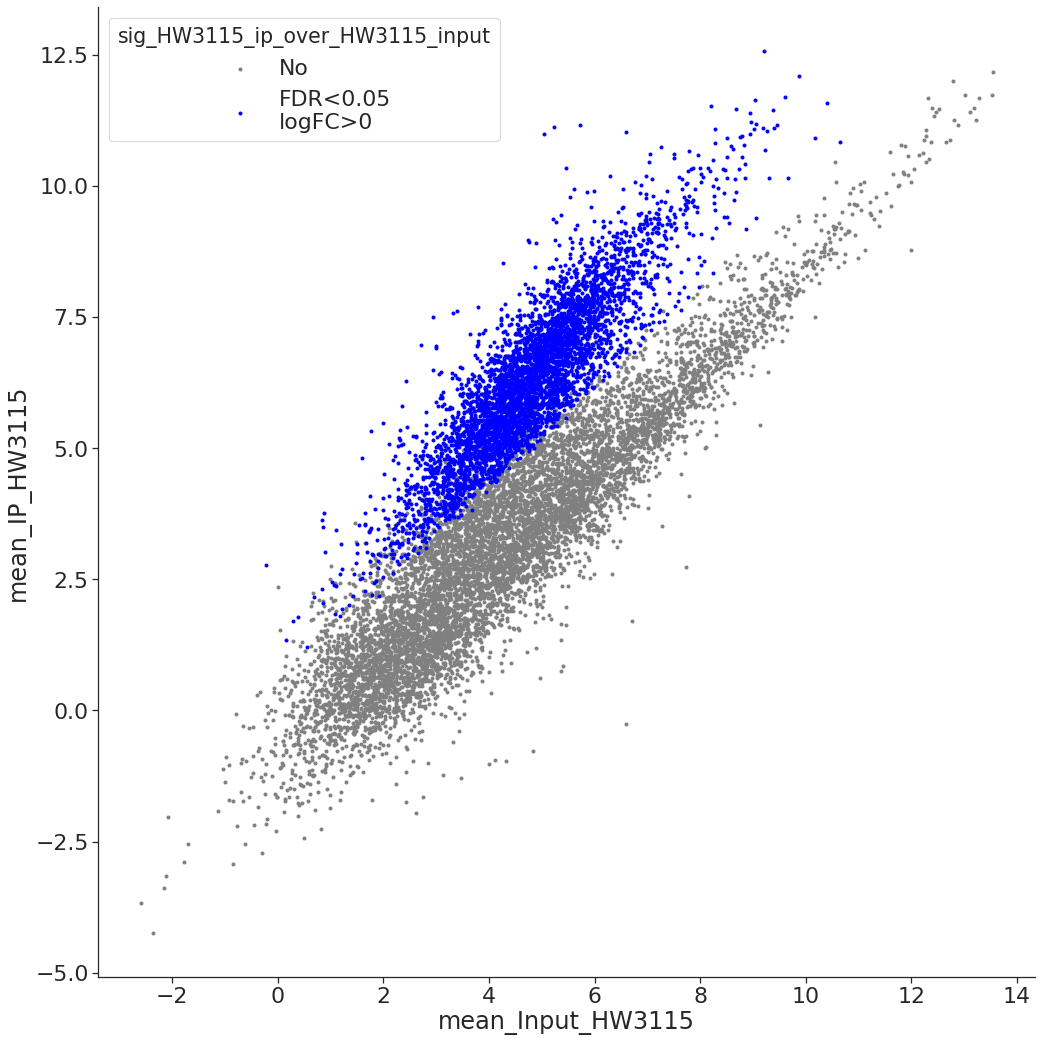

In [52]:
sns_plot = sns.lmplot(x=f"mean_Input_HW3115",
                      y=f"mean_IP_HW3115",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_HW3115_ip_over_HW3115_input",
                      hue_order=["No", "FDR<0.05\nlogFC>0"],
                      palette=["grey", "blue", "black"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_Input_HW3115__vs__mean_IP_HW3115.pdf")

# scatterplot HW3115 IP over HW3128 IP

In [53]:
df_short = df[["Name",
               "length",
               "HW3115_Replicate_A_IP",
               "HW3115_Replicate_B_IP",
               "HW3115_Replicate_C_IP",
               "HW3128_Replicate_A_IP",
               "HW3128_Replicate_B_IP",
               "HW3128_Replicate_C_IP"]].copy()

tpm = counts2tpm(df_short)

tpm["mean_IP_HW3115"] = tpm[["HW3115_Replicate_A_IP", "HW3115_Replicate_B_IP", "HW3115_Replicate_C_IP"]].mean(axis=1)
tpm["mean_IP_HW3128"] = tpm[["HW3128_Replicate_A_IP", "HW3128_Replicate_B_IP", "HW3128_Replicate_C_IP"]].mean(axis=1)

/tungstenfs/nobackup/ggrossha/gypafoiv/miniconda3/envs/python_3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



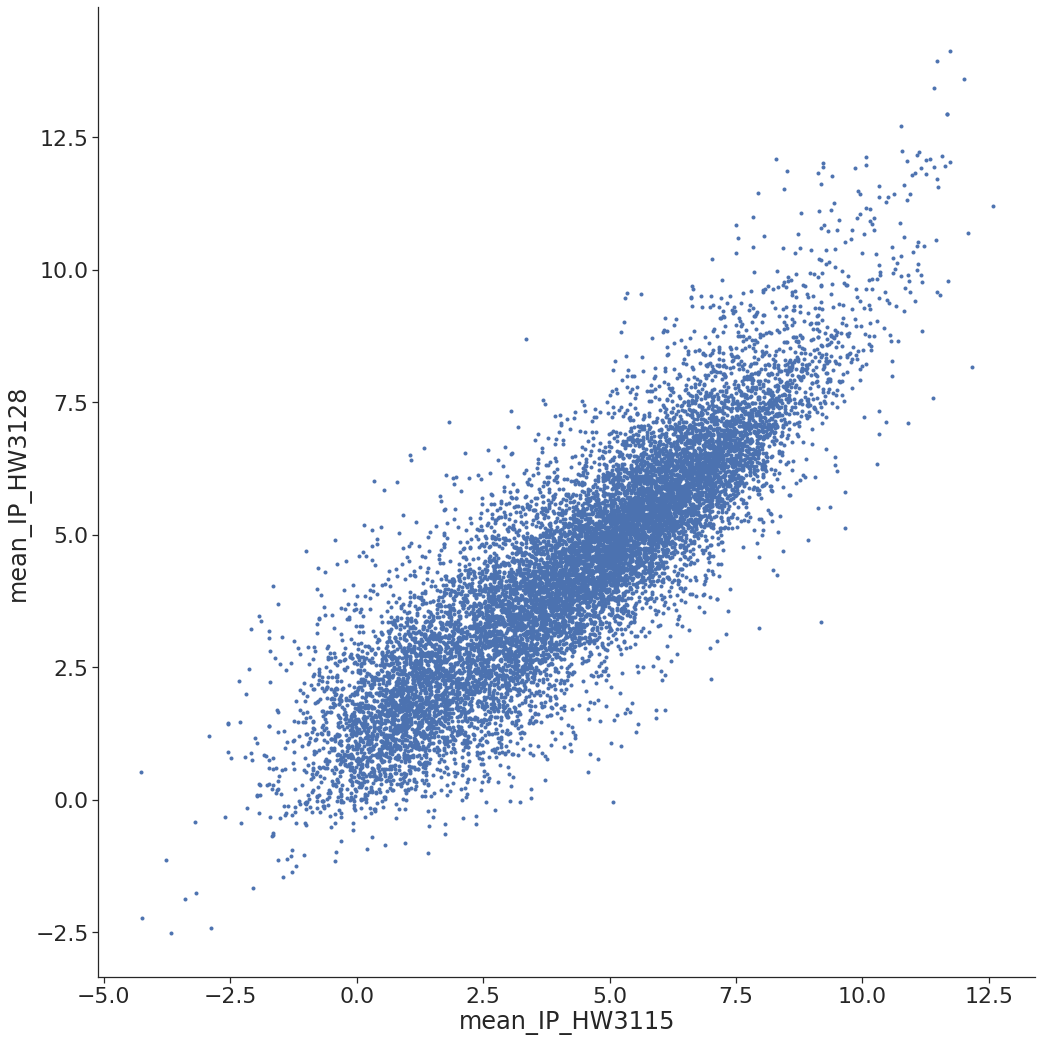

In [54]:
sns_plot = sns.lmplot(x=f"mean_IP_HW3115",
                      y=f"mean_IP_HW3128",
                      data=tpm,
                      fit_reg=False,
                      palette=["grey", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3115__vs__mean_IP_HW3128.pdf")

# scatterplot HW3115 IP over HW3128 IP (add FCs)

In [55]:
df_HW3115_ip_over_HW3128_dpf3_ip = pd.read_csv("../../04_csr1_ip_and_wago_double_mutants/results/filter/DE_htseq_count__1_alignment_per_read__reverse__HW3128_IP__HW3115_IP/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                                               header=0,
                                               sep="\t")

In [56]:
tpm["sig_HW3115_ip_over_HW3128_dpf3_ip"] = "No"
tpm.loc[tpm.index.isin(list(df_HW3115_ip_over_HW3128_dpf3_ip[df_HW3115_ip_over_HW3128_dpf3_ip["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_HW3115_ip_over_HW3128_dpf3_ip[df_HW3115_ip_over_HW3128_dpf3_ip["logFC"]>0]["id"])), "sig_HW3115_ip_over_HW3128_dpf3_ip"] = "FDR<0.05\nlogFC>0"
tpm.loc[tpm.index.isin(list(df_HW3115_ip_over_HW3128_dpf3_ip[df_HW3115_ip_over_HW3128_dpf3_ip["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_HW3115_ip_over_HW3128_dpf3_ip[df_HW3115_ip_over_HW3128_dpf3_ip["logFC"]<0]["id"])), "sig_HW3115_ip_over_HW3128_dpf3_ip"] = "FDR<0.05\nlogFC<0"

In [57]:
print(tpm["sig_HW3115_ip_over_HW3128_dpf3_ip"].value_counts())

No                   7942
FDR<0.05\nlogFC>0    3355
FDR<0.05\nlogFC<0    1403
Name: sig_HW3115_ip_over_HW3128_dpf3_ip, dtype: int64


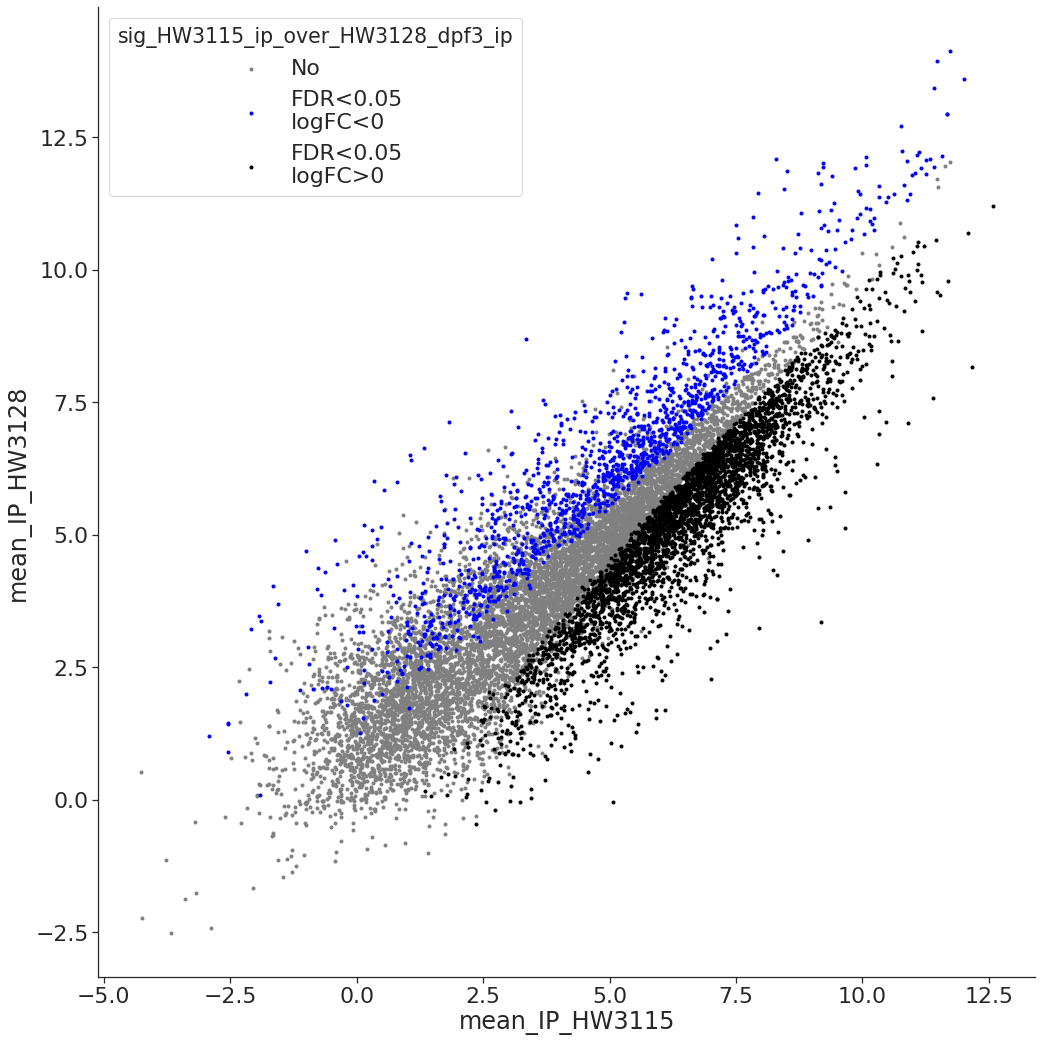

In [58]:
sns_plot = sns.lmplot(x=f"mean_IP_HW3115",
                      y=f"mean_IP_HW3128",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_HW3115_ip_over_HW3128_dpf3_ip",
                      hue_order=["No", "FDR<0.05\nlogFC<0", "FDR<0.05\nlogFC>0"],
                      palette=["grey", "blue", "black"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3115__vs__mean_IP_HW3128__mark_sig_HW3115_ip_over_HW3128_dpf3_ip.pdf")

In [59]:
pd.DataFrame(tpm[tpm["sig_HW3115_ip_over_HW3128_dpf3_ip"] == "FDR<0.05\nlogFC<0"].index).to_csv("HW3128_over_HW3115_specific.txt",
                                                                                                header=None,
                                                                                                index=None)

# scatterplot HW3115 IP over HW3128 IP (overlay WAGO-1 IP over Input)

In [60]:
# read in the wago-1 ip over input bound
df_wago1_ip_over_wago1_input = pd.read_csv("../../03_WAGO_IPs/results/filter/DE_htseq_count__1_alignment_per_read__reverse__Input_WAGO-1__IP_WAGO-1/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                                     header=0,
                                     sep="\t")

In [61]:
tpm["sig_wago1_ip_over_wago1_input"] = "No"

In [62]:
tpm.loc[tpm.index.isin(list(df_wago1_ip_over_wago1_input[df_wago1_ip_over_wago1_input["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_wago1_ip_over_wago1_input[df_wago1_ip_over_wago1_input["logFC"]>0]["id"])), "sig_wago1_ip_over_wago1_input"] = "FDR<0.05\nlogFC>0"

In [63]:
print(tpm["sig_wago1_ip_over_wago1_input"].value_counts())

No                   8847
FDR<0.05\nlogFC>0    3853
Name: sig_wago1_ip_over_wago1_input, dtype: int64


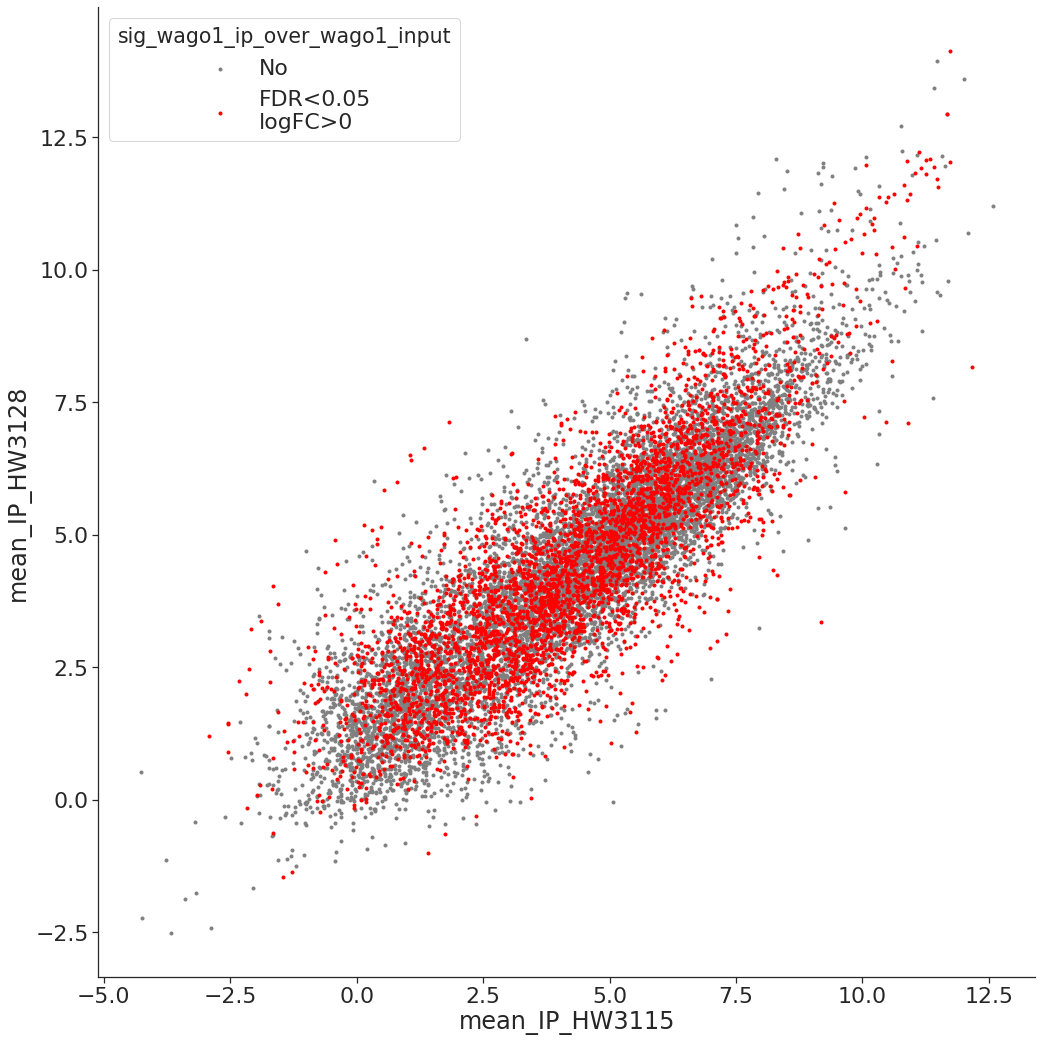

In [64]:
sns_plot = sns.lmplot(x=f"mean_IP_HW3115",
                      y=f"mean_IP_HW3128",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_wago1_ip_over_wago1_input",
                      hue_order=["No","FDR<0.05\nlogFC>0"],
                      palette=["grey", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3115__vs__mean_IP_HW3128__mark_sig_wago1_ip_over_wago1_input.pdf")

In [65]:
tpm["Significant"] = "No"
tpm.loc[tpm["sig_HW3115_ip_over_HW3128_dpf3_ip"] == "FDR<0.05\nlogFC>0", "Significant"] = "HW3115 specific"
tpm.loc[tpm["sig_HW3115_ip_over_HW3128_dpf3_ip"] == "FDR<0.05\nlogFC<0", "Significant"] = "HW3128 specific"

In [66]:
tpm.loc[tpm["sig_wago1_ip_over_wago1_input"] == "FDR<0.05\nlogFC>0", "Significant"] = "wago1 specific"

In [67]:
print(tpm["Significant"].value_counts())

No                 5559
wago1 specific     3853
HW3115 specific    2480
HW3128 specific     808
Name: Significant, dtype: int64


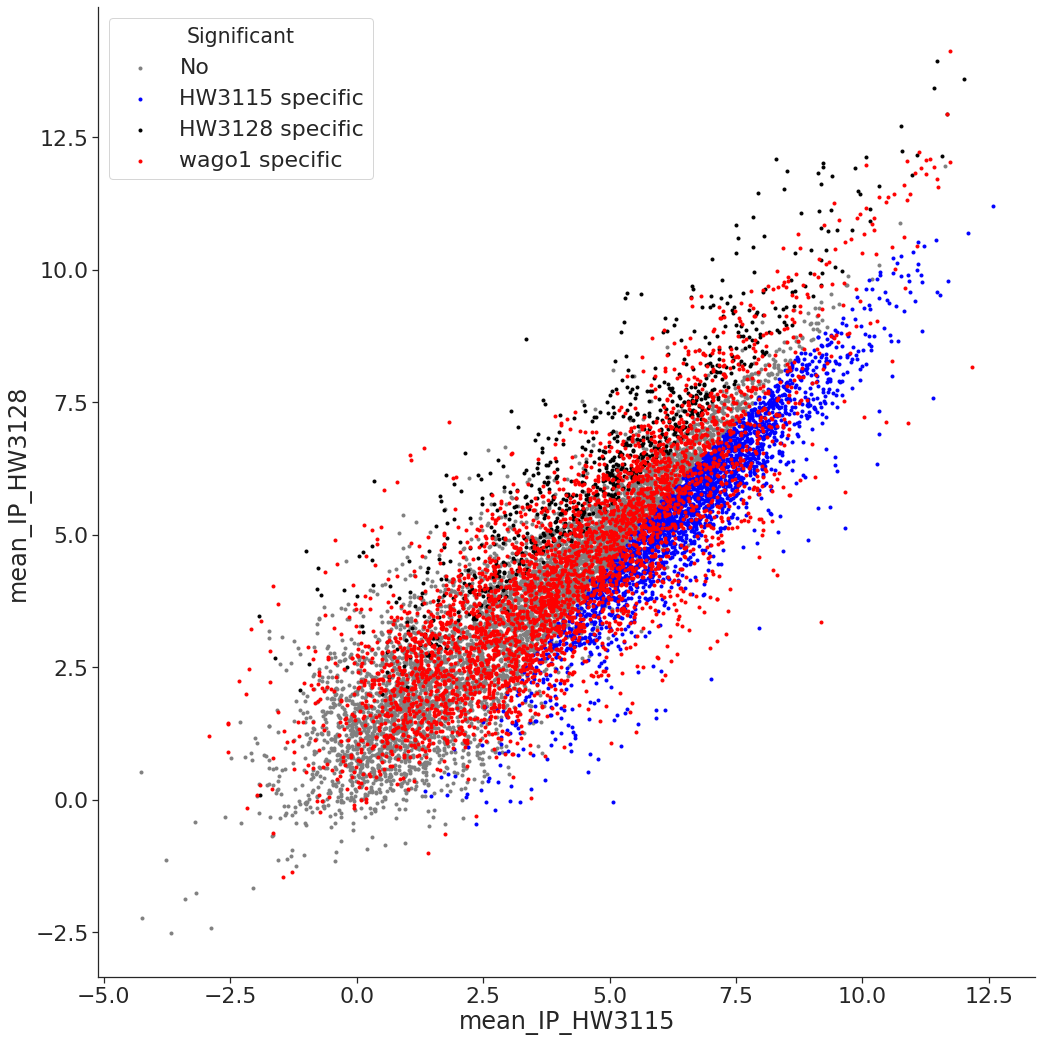

In [68]:
sns_plot = sns.lmplot(x=f"mean_IP_HW3115",
                      y=f"mean_IP_HW3128",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
                      hue_order=["No", "HW3115 specific", "HW3128 specific", "wago1 specific"],
                      palette=["grey", "blue", "black", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3115__vs__mean_IP_HW3128__mark_HW3115_HW3128_sig_wago1_ip_over_wago1_input.pdf")

# scatterplot HW3115 IP over HW3128 IP (overlay WAGO-1 IP over WAGO-1 dpf-3 null IP)

In [69]:
df_wago1_ip_over_wago1_dpf_3_null_ip = pd.read_csv("../../03_WAGO_IPs/results/filter/DE_htseq_count__1_alignment_per_read__reverse__IP_WAGO-1_dpf-3_null__IP_WAGO-1/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                                                   header=0,
                                                   sep="\t")

In [70]:
tpm["sig_wago1_ip_over_wago1_dpf_3_null_ip"] = "No"

In [71]:
tpm.loc[tpm.index.isin(list(df_wago1_ip_over_wago1_dpf_3_null_ip[df_wago1_ip_over_wago1_dpf_3_null_ip["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_wago1_ip_over_wago1_dpf_3_null_ip[df_wago1_ip_over_wago1_dpf_3_null_ip["logFC"]>0]["id"])), "sig_wago1_ip_over_wago1_dpf_3_null_ip"] = "FDR<0.05\nlogFC>0"

In [72]:
print(tpm["sig_wago1_ip_over_wago1_dpf_3_null_ip"].value_counts())

No                   9760
FDR<0.05\nlogFC>0    2940
Name: sig_wago1_ip_over_wago1_dpf_3_null_ip, dtype: int64


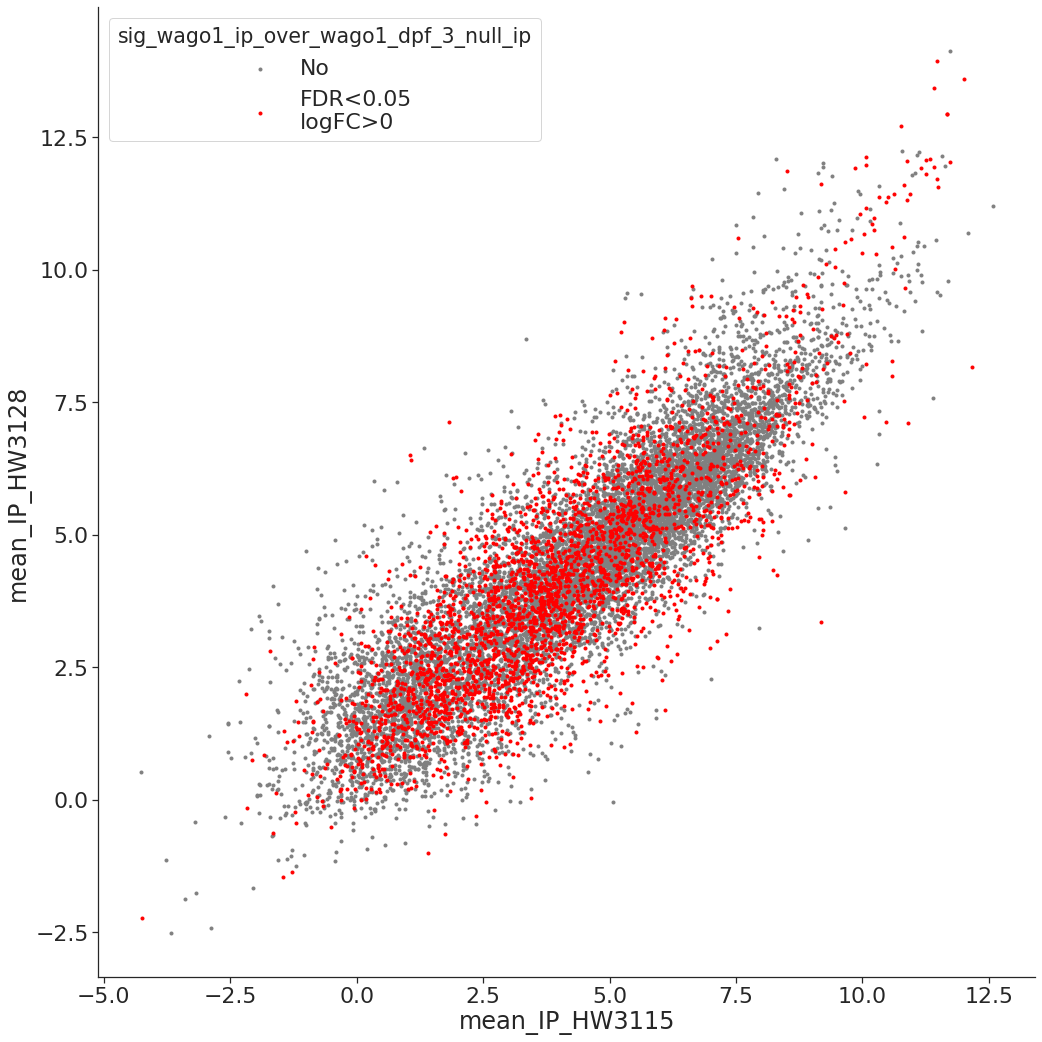

In [73]:
sns_plot = sns.lmplot(x=f"mean_IP_HW3115",
                      y=f"mean_IP_HW3128",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_wago1_ip_over_wago1_dpf_3_null_ip",
                      hue_order=["No","FDR<0.05\nlogFC>0"],
                      palette=["grey", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3115__vs__mean_IP_HW3128__mark_sig_wago1_ip_over_wago1_dpf_3_null_ip.pdf")

In [74]:
tpm["Significant"] = "No"
tpm.loc[tpm["sig_HW3115_ip_over_HW3128_dpf3_ip"] == "FDR<0.05\nlogFC>0", "Significant"] = "HW3115 specific"
tpm.loc[tpm["sig_HW3115_ip_over_HW3128_dpf3_ip"] == "FDR<0.05\nlogFC<0", "Significant"] = "HW3128 specific"

In [75]:
tpm.loc[tpm["sig_wago1_ip_over_wago1_dpf_3_null_ip"] == "FDR<0.05\nlogFC>0", "Significant"] = "wago1 specific"

In [76]:
print(tpm["Significant"].value_counts())

No                 5919
wago1 specific     2940
HW3115 specific    2762
HW3128 specific    1079
Name: Significant, dtype: int64


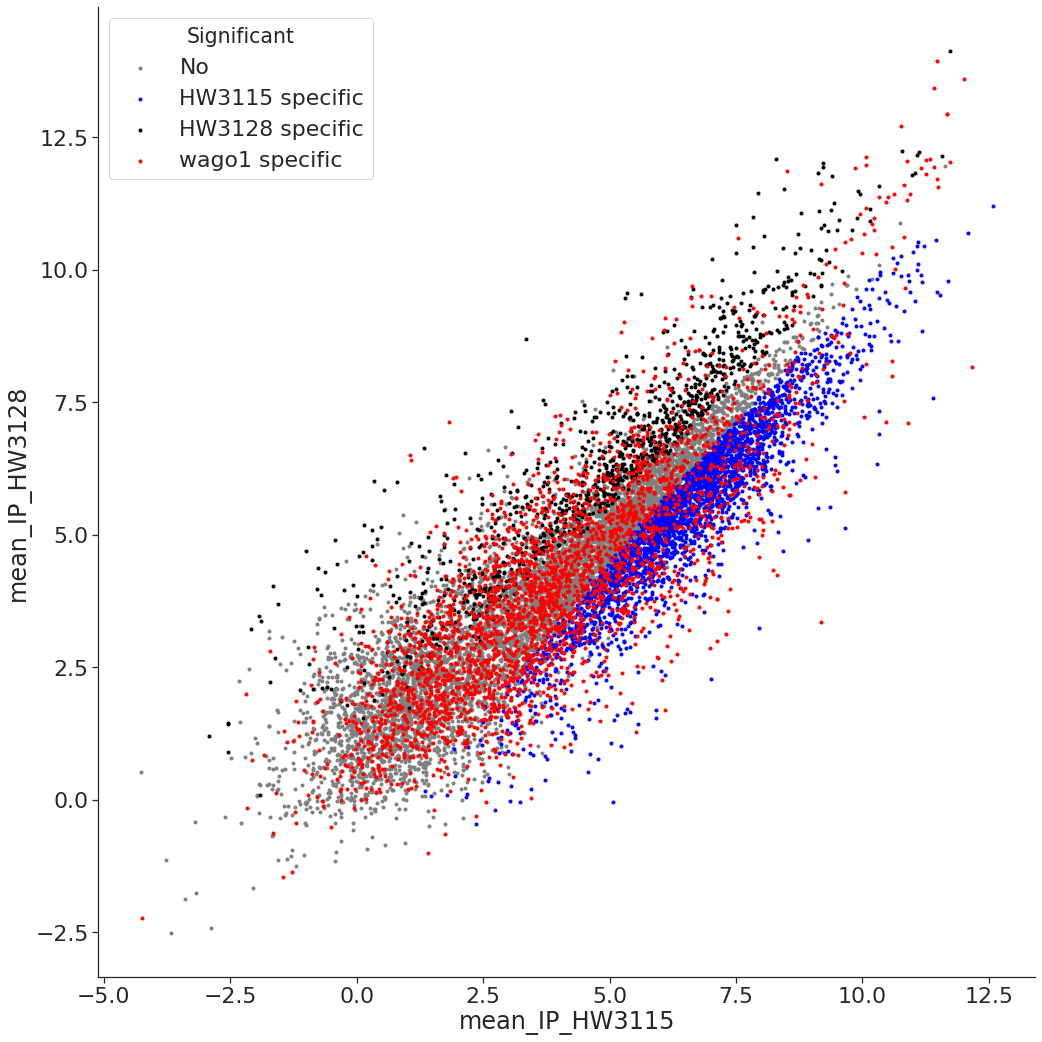

In [77]:
sns_plot = sns.lmplot(x=f"mean_IP_HW3115",
                      y=f"mean_IP_HW3128",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
                      hue_order=["No", "HW3115 specific", "HW3128 specific", "wago1 specific"],
                      palette=["grey", "blue", "black", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3115__vs__mean_IP_HW3128__mark_HW3115_HW3128_sig_wago1_ip_over_wago1_dpf_3_null_ip.pdf")

# scatterplot HW3115 IP over HW3128 IP (overlay WAGO-3 IP over Input)

In [78]:
# read in the wago-3 ip over input bound
df_wago3_ip_over_wago3_input = pd.read_csv("../../03_WAGO_IPs/results/filter/DE_htseq_count__1_alignment_per_read__reverse__Input_WAGO-3__IP_WAGO-3/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                                           header=0,
                                           sep="\t")

In [79]:
tpm["sig_wago3_ip_over_wago3_input"] = "No"

In [80]:
tpm.loc[tpm.index.isin(list(df_wago3_ip_over_wago3_input[df_wago3_ip_over_wago3_input["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_wago3_ip_over_wago3_input[df_wago3_ip_over_wago3_input["logFC"]>0]["id"])), "sig_wago3_ip_over_wago3_input"] = "FDR<0.05\nlogFC>0"

In [81]:
print(tpm["sig_wago3_ip_over_wago3_input"].value_counts())

No                   9519
FDR<0.05\nlogFC>0    3181
Name: sig_wago3_ip_over_wago3_input, dtype: int64


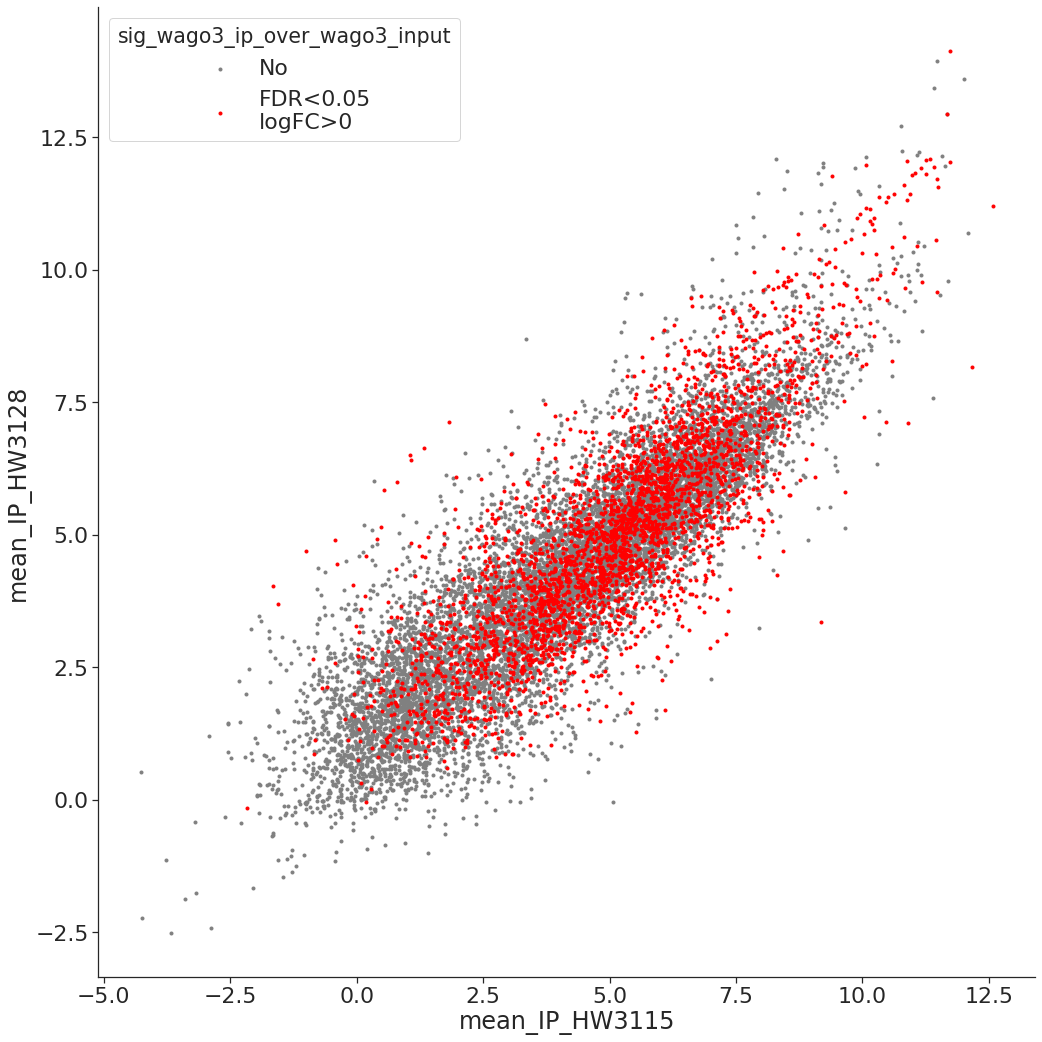

In [82]:
sns_plot = sns.lmplot(x=f"mean_IP_HW3115",
                      y=f"mean_IP_HW3128",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_wago3_ip_over_wago3_input",
                      hue_order=["No","FDR<0.05\nlogFC>0"],
                      palette=["grey", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3115__vs__mean_IP_HW3128__mark_sig_wago3_ip_over_wago3_input.pdf")

In [83]:
tpm["Significant"] = "No"
tpm.loc[tpm["sig_HW3115_ip_over_HW3128_dpf3_ip"] == "FDR<0.05\nlogFC>0", "Significant"] = "HW3115 specific"
tpm.loc[tpm["sig_HW3115_ip_over_HW3128_dpf3_ip"] == "FDR<0.05\nlogFC<0", "Significant"] = "HW3128 specific"

In [84]:
tpm.loc[tpm["sig_wago3_ip_over_wago3_input"] == "FDR<0.05\nlogFC>0", "Significant"] = "wago3 specific"

In [85]:
print(tpm["Significant"].value_counts())

No                 6215
wago3 specific     3181
HW3115 specific    2413
HW3128 specific     891
Name: Significant, dtype: int64


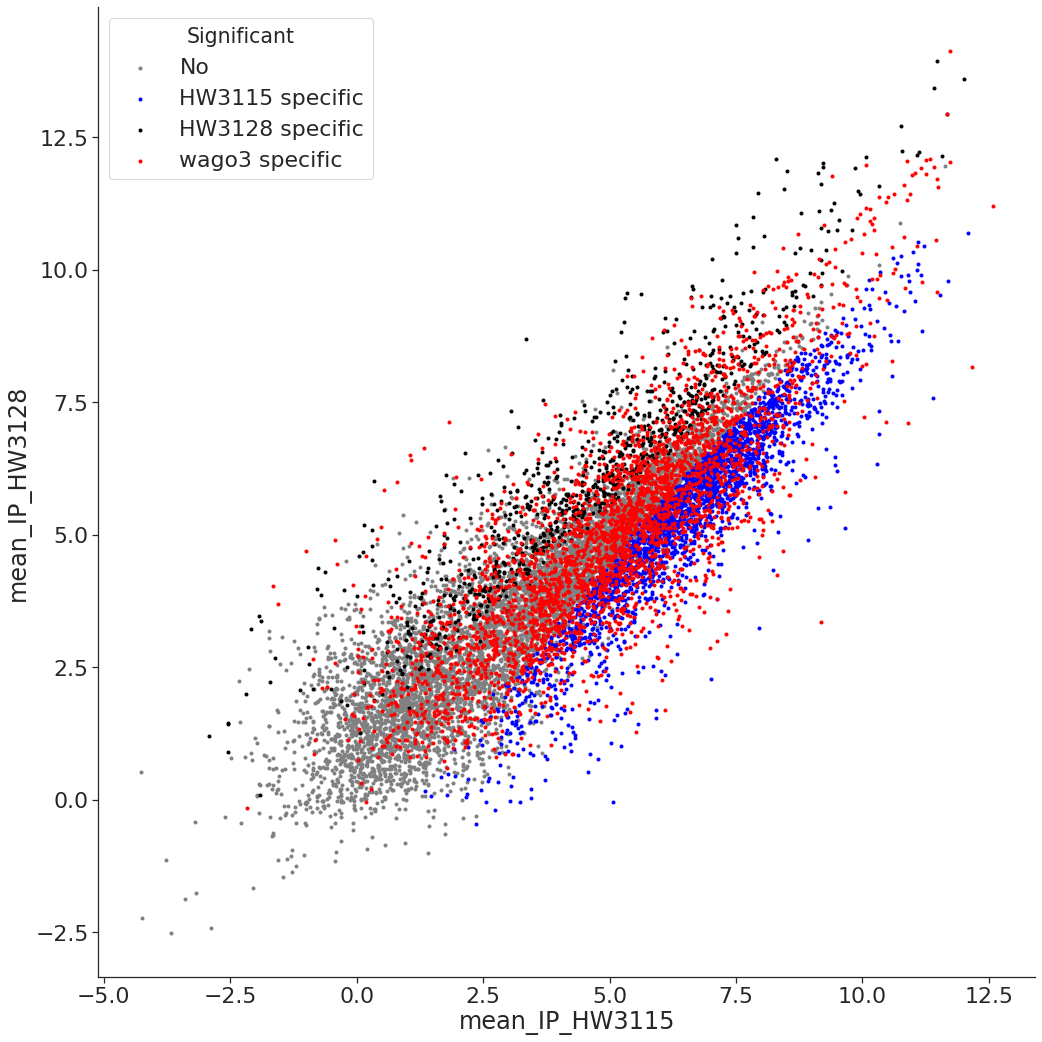

In [86]:
sns_plot = sns.lmplot(x=f"mean_IP_HW3115",
                      y=f"mean_IP_HW3128",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
                      hue_order=["No", "HW3115 specific", "HW3128 specific", "wago3 specific"],
                      palette=["grey", "blue", "black", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3115__vs__mean_IP_HW3128__mark_HW3115_HW3128_sig_wago3_ip_over_wago3_input.pdf")

# scatterplot HW3134 IP over HW3134 Input

In [87]:
df.columns

Index(['Name', 'length', 'Input_WAGO-1_A', 'Input_WAGO-1_B', 'Input_WAGO-1_C',
       'Input_WAGO-1_dpf-3_null_A', 'Input_WAGO-1_dpf-3_null_B',
       'Input_WAGO-1_dpf-3_null_C', 'Input_WAGO-1_P3G_A', 'Input_WAGO-1_P3G_B',
       'Input_WAGO-1_P3G_C', 'Input_WAGO-3_A', 'Input_WAGO-3_B',
       'Input_WAGO-3_C', 'Input_WAGO-3_dpf-3_null_A',
       'Input_WAGO-3_dpf-3_null_B', 'Input_WAGO-3_dpf-3_null_C',
       'Input_WAGO-4_A', 'Input_WAGO-4_B', 'Input_WAGO-4_C',
       'Input_WAGO-4_dpf-3_null_A', 'Input_WAGO-4_dpf-3_null_B',
       'Input_WAGO-4_dpf-3_null_C', 'IP_WAGO-1_A', 'IP_WAGO-1_B',
       'IP_WAGO-1_C', 'IP_WAGO-1_dpf-3_null_A', 'IP_WAGO-1_dpf-3_null_B',
       'IP_WAGO-1_dpf-3_null_C', 'IP_WAGO-1_P3G_A', 'IP_WAGO-1_P3G_B',
       'IP_WAGO-1_P3G_C', 'IP_WAGO-3_A', 'IP_WAGO-3_B', 'IP_WAGO-3_C',
       'IP_WAGO-3_dpf-3_null_A', 'IP_WAGO-3_dpf-3_null_B',
       'IP_WAGO-3_dpf-3_null_C', 'IP_WAGO-4_A', 'IP_WAGO-4_B', 'IP_WAGO-4_C',
       'IP_WAGO-4_dpf-3_null_A', 'IP_WAGO-4_dpf

In [88]:
df_short = df[["Name",
               "length",
               "HW3134_Replicate_A_IP",
               "HW3134_Replicate_B_IP",
               "HW3134_Replicate_C_IP",
               "HW3135_Replicate_A_INPUT",
               "HW3135_Replicate_B_INPUT",
               "HW3135_Replicate_C_INPUT"]].copy()

tpm = counts2tpm(df_short)

tpm["mean_IP_HW3134"] = tpm[["HW3134_Replicate_A_IP", "HW3134_Replicate_B_IP", "HW3134_Replicate_C_IP"]].mean(axis=1)
tpm["mean_Input_HW3134"] = tpm[["HW3135_Replicate_A_INPUT", "HW3135_Replicate_B_INPUT", "HW3135_Replicate_C_INPUT"]].mean(axis=1)

/tungstenfs/nobackup/ggrossha/gypafoiv/miniconda3/envs/python_3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [89]:
# read in the wago-1 ip over input bound
df_HW3134_ip_over_HW3134_input = pd.read_csv("../../04_csr1_ip_and_wago_double_mutants/results/filter/DE_htseq_count__1_alignment_per_read__reverse__HW3134_INPUT__HW3134_IP/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                                             header=0,
                                             sep="\t")

In [90]:
tpm["sig_HW3134_ip_over_HW3134_input"] = "No"
tpm.loc[tpm.index.isin(list(df_HW3134_ip_over_HW3134_input[df_HW3134_ip_over_HW3134_input["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_HW3134_ip_over_HW3134_input[df_HW3134_ip_over_HW3134_input["logFC"]>0]["id"])), "sig_HW3134_ip_over_HW3134_input"] = "FDR<0.05\nlogFC>0"

In [91]:
print(tpm["sig_HW3134_ip_over_HW3134_input"].value_counts())

No                   13868
FDR<0.05\nlogFC>0     5505
Name: sig_HW3134_ip_over_HW3134_input, dtype: int64


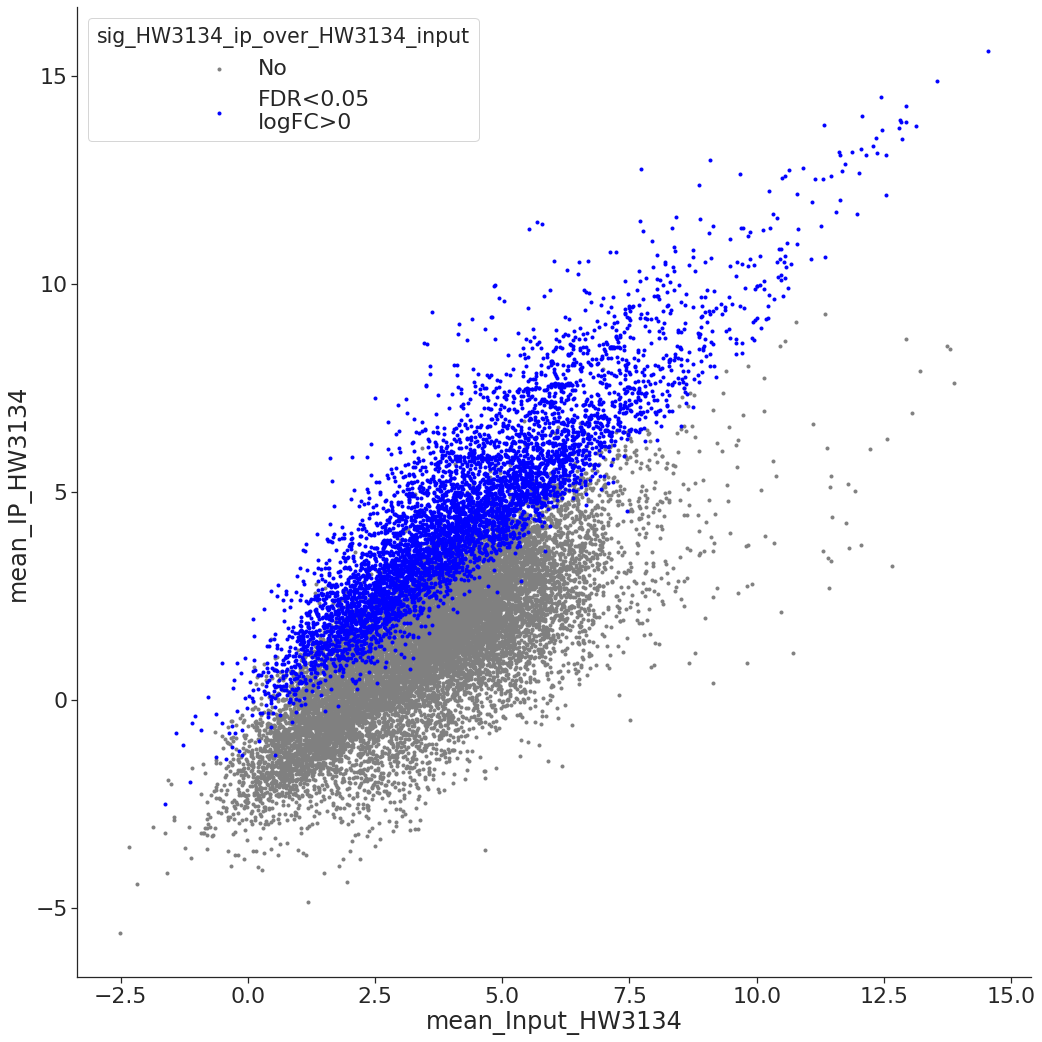

In [92]:
sns_plot = sns.lmplot(x=f"mean_Input_HW3134",
                      y=f"mean_IP_HW3134",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_HW3134_ip_over_HW3134_input",
                      hue_order=["No", "FDR<0.05\nlogFC>0"],
                      palette=["grey", "blue", "black"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

# scatterplot HW3134 IP over WAGO-1 IP

In [93]:
df.columns

Index(['Name', 'length', 'Input_WAGO-1_A', 'Input_WAGO-1_B', 'Input_WAGO-1_C',
       'Input_WAGO-1_dpf-3_null_A', 'Input_WAGO-1_dpf-3_null_B',
       'Input_WAGO-1_dpf-3_null_C', 'Input_WAGO-1_P3G_A', 'Input_WAGO-1_P3G_B',
       'Input_WAGO-1_P3G_C', 'Input_WAGO-3_A', 'Input_WAGO-3_B',
       'Input_WAGO-3_C', 'Input_WAGO-3_dpf-3_null_A',
       'Input_WAGO-3_dpf-3_null_B', 'Input_WAGO-3_dpf-3_null_C',
       'Input_WAGO-4_A', 'Input_WAGO-4_B', 'Input_WAGO-4_C',
       'Input_WAGO-4_dpf-3_null_A', 'Input_WAGO-4_dpf-3_null_B',
       'Input_WAGO-4_dpf-3_null_C', 'IP_WAGO-1_A', 'IP_WAGO-1_B',
       'IP_WAGO-1_C', 'IP_WAGO-1_dpf-3_null_A', 'IP_WAGO-1_dpf-3_null_B',
       'IP_WAGO-1_dpf-3_null_C', 'IP_WAGO-1_P3G_A', 'IP_WAGO-1_P3G_B',
       'IP_WAGO-1_P3G_C', 'IP_WAGO-3_A', 'IP_WAGO-3_B', 'IP_WAGO-3_C',
       'IP_WAGO-3_dpf-3_null_A', 'IP_WAGO-3_dpf-3_null_B',
       'IP_WAGO-3_dpf-3_null_C', 'IP_WAGO-4_A', 'IP_WAGO-4_B', 'IP_WAGO-4_C',
       'IP_WAGO-4_dpf-3_null_A', 'IP_WAGO-4_dpf

In [94]:
df_short = df[["Name",
               "length",
               "HW3134_Replicate_A_IP",
               "HW3134_Replicate_B_IP",
               "HW3134_Replicate_C_IP",
               "IP_WAGO-1_A",
               "IP_WAGO-1_B",
               "IP_WAGO-1_C"]].copy()

tpm = counts2tpm(df_short)

tpm["mean_IP_HW3134"] = tpm[["HW3134_Replicate_A_IP", "HW3134_Replicate_B_IP", "HW3134_Replicate_C_IP"]].mean(axis=1)
tpm["mean_IP_WAGO-1"] = tpm[["IP_WAGO-1_A", "IP_WAGO-1_B", "IP_WAGO-1_C"]].mean(axis=1)

In [95]:
# read in the wago-1 ip over input bound
df_HW3134_ip_over_WAGO_1_ip = pd.read_csv("../../04_csr1_ip_and_wago_double_mutants/results/filter/DE_htseq_count__1_alignment_per_read__reverse__IP_WAGO-1__HW3134_IP/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                                             header=0,
                                             sep="\t")

In [96]:
tpm["sig_HW3134_ip_over_WAGO_1_ip"] = "No"
tpm.loc[tpm.index.isin(list(df_HW3134_ip_over_WAGO_1_ip[df_HW3134_ip_over_WAGO_1_ip["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_HW3134_ip_over_WAGO_1_ip[df_HW3134_ip_over_WAGO_1_ip["logFC"]>0]["id"])), "sig_HW3134_ip_over_WAGO_1_ip"] = "FDR<0.05\nlogFC>0"
tpm.loc[tpm.index.isin(list(df_HW3134_ip_over_WAGO_1_ip[df_HW3134_ip_over_WAGO_1_ip["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_HW3134_ip_over_WAGO_1_ip[df_HW3134_ip_over_WAGO_1_ip["logFC"]<0]["id"])), "sig_HW3134_ip_over_WAGO_1_ip"] = "FDR<0.05\nlogFC<0"

In [97]:
print(tpm["sig_HW3134_ip_over_WAGO_1_ip"].value_counts())

No                   12464
FDR<0.05\nlogFC>0     5814
FDR<0.05\nlogFC<0     3306
Name: sig_HW3134_ip_over_WAGO_1_ip, dtype: int64


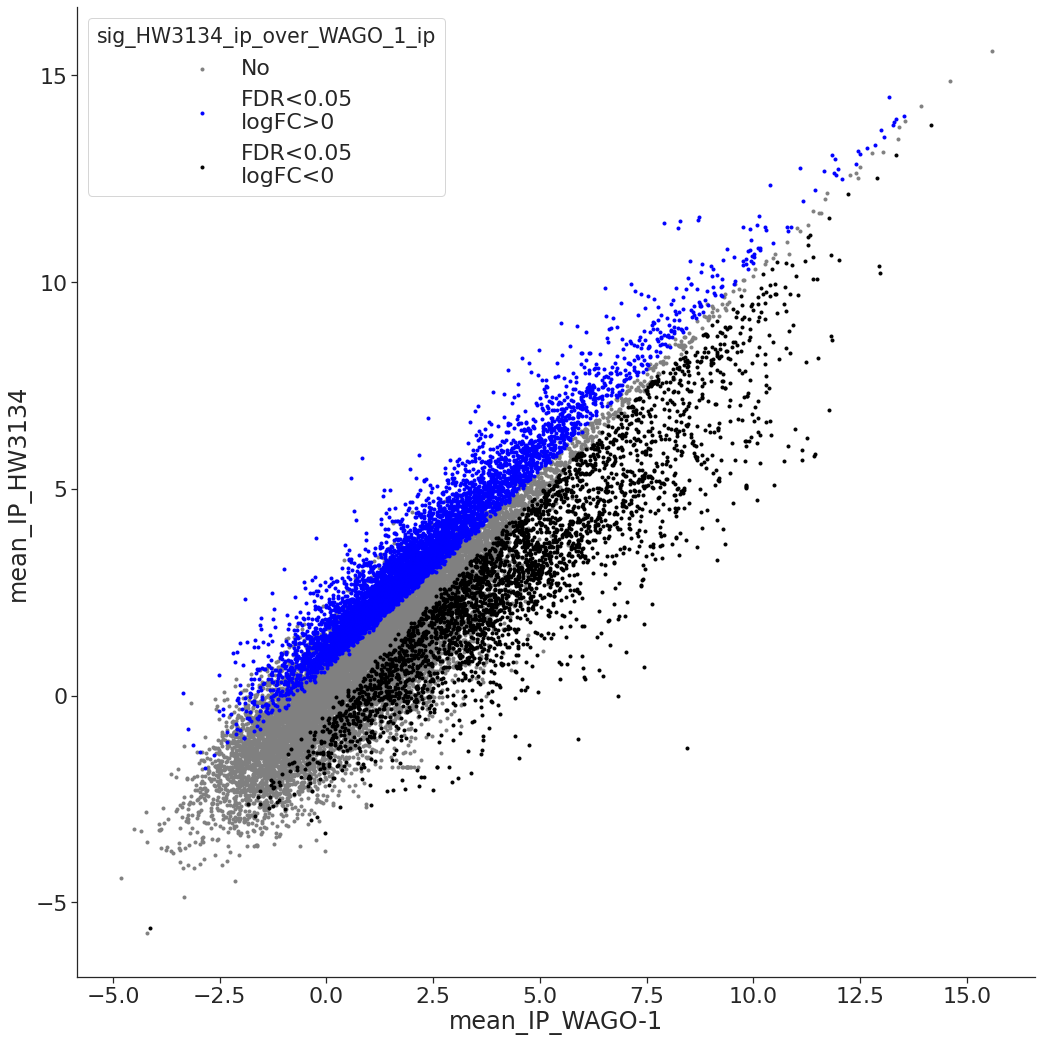

In [98]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_HW3134",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_HW3134_ip_over_WAGO_1_ip",
                      hue_order=["No", "FDR<0.05\nlogFC>0", "FDR<0.05\nlogFC<0"],
                      palette=["grey", "blue", "black"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3134__vs__mean_IP_WAGO_1__sig_HW3134_ip_over_WAGO_1_ip.pdf")

# same as before but overlay the csr-1 bound

In [99]:
# read in the HW3115 ip over input bound
df_HW3115_ip_over_HW3115_input = pd.read_csv("../../04_csr1_ip_and_wago_double_mutants/results/filter/DE_htseq_count__1_alignment_per_read__reverse__HW3115_INPUT__HW3115_IP/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                                             header=0,
                                             sep="\t")

In [100]:
tpm["sig_HW3115_ip_over_HW3115_input"] = "No"

In [101]:
tpm.loc[tpm.index.isin(list(df_HW3115_ip_over_HW3115_input[df_HW3115_ip_over_HW3115_input["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_HW3115_ip_over_HW3115_input[df_HW3115_ip_over_HW3115_input["logFC"]>0]["id"])), "sig_HW3115_ip_over_HW3115_input"] = "FDR<0.05\nlogFC>0"

In [102]:
print(tpm["sig_HW3115_ip_over_HW3115_input"].value_counts())

No                   16920
FDR<0.05\nlogFC>0     4664
Name: sig_HW3115_ip_over_HW3115_input, dtype: int64


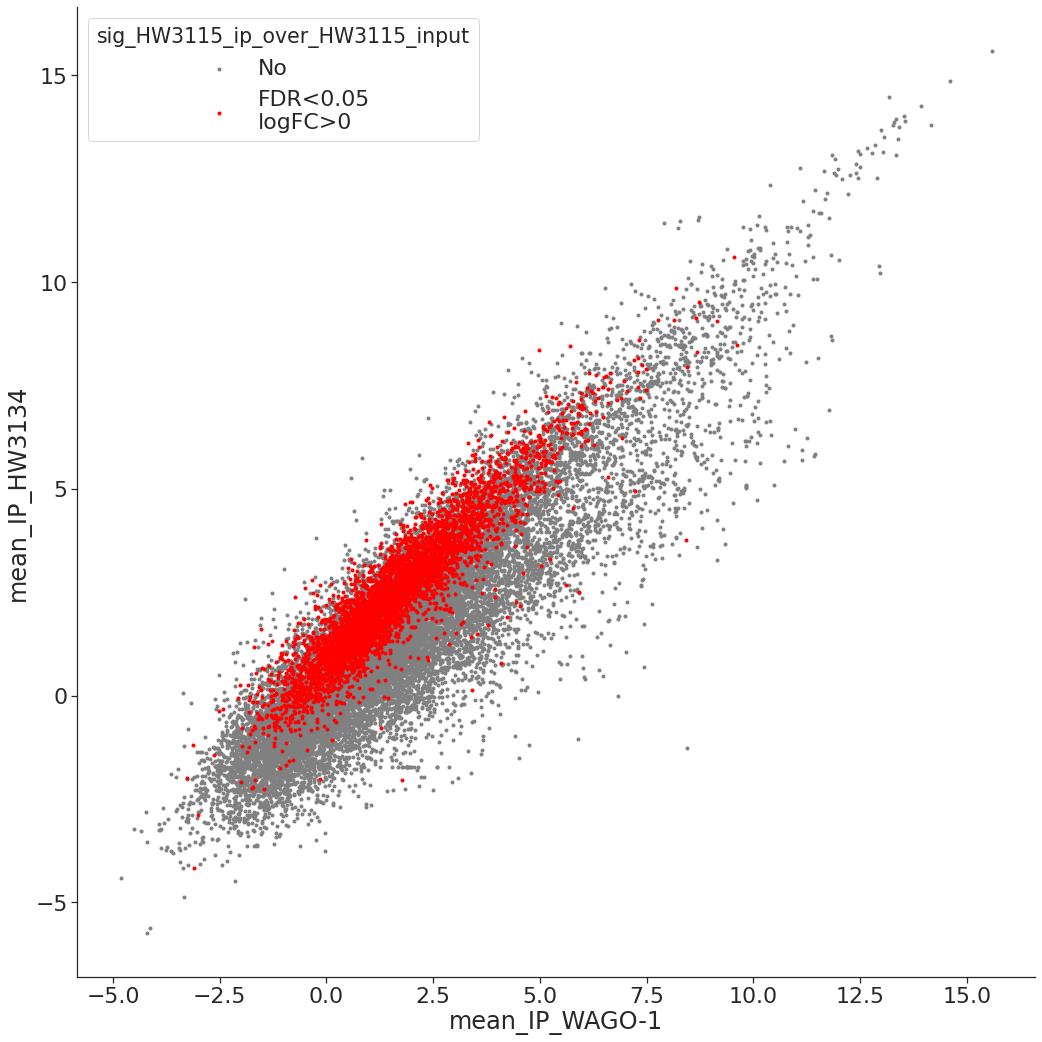

In [103]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_HW3134",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_HW3115_ip_over_HW3115_input",
                      hue_order=["No","FDR<0.05\nlogFC>0"],
                      palette=["grey", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3134__vs__mean_IP_WAGO_1__mark_sig_HW3115_ip_over_HW3115_input.pdf")

# combine the last two plots

In [104]:
tpm["Significant"] = "No"
tpm.loc[tpm["sig_HW3134_ip_over_WAGO_1_ip"] == "FDR<0.05\nlogFC>0", "Significant"] = "HW3134 IP specific"
tpm.loc[tpm["sig_HW3134_ip_over_WAGO_1_ip"] == "FDR<0.05\nlogFC<0", "Significant"] = "WAGO-1 IP specific"

In [105]:
tpm.loc[tpm["sig_HW3115_ip_over_HW3115_input"] == "FDR<0.05\nlogFC>0", "Significant"] = "csr-1 specific"

In [106]:
print(tpm["Significant"].value_counts())

No                    10916
csr-1 specific         4664
WAGO-1 IP specific     3186
HW3134 IP specific     2818
Name: Significant, dtype: int64


In [107]:
tpm.columns

Index(['HW3134_Replicate_A_IP', 'HW3134_Replicate_B_IP',
       'HW3134_Replicate_C_IP', 'IP_WAGO-1_A', 'IP_WAGO-1_B', 'IP_WAGO-1_C',
       'mean_IP_HW3134', 'mean_IP_WAGO-1', 'sig_HW3134_ip_over_WAGO_1_ip',
       'sig_HW3115_ip_over_HW3115_input', 'Significant'],
      dtype='object')

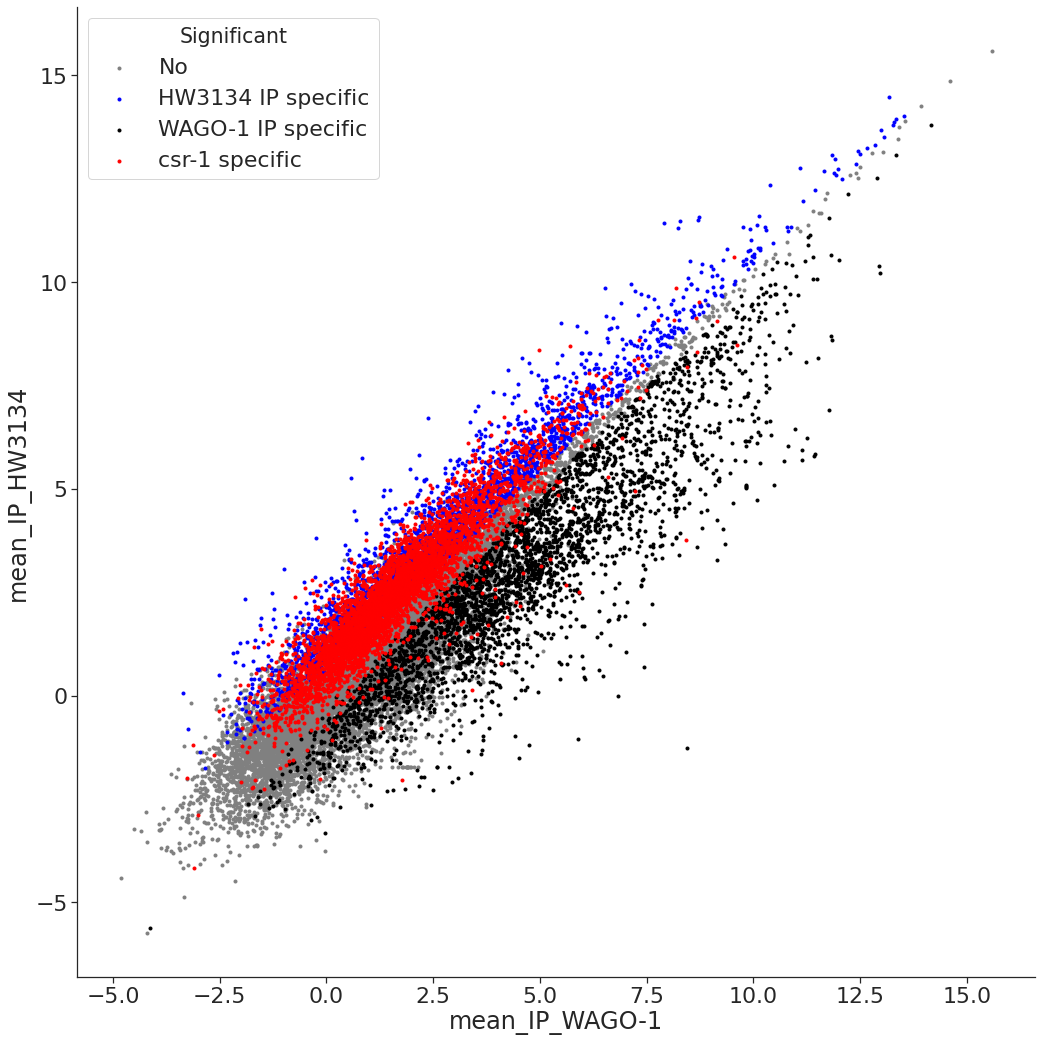

In [108]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_HW3134",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
                      hue_order=["No", "HW3134 IP specific", "WAGO-1 IP specific", "csr-1 specific"],
                      palette=["grey", "blue", "black", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3134__vs__mean_IP_WAGO_1__mark_HW3134_IP_WAGO_1_IP_sig_HW3115_ip_over_HW3115_input.pdf")

# scatterplot HW3135 IP over WAGO-1 IP

In [109]:
df_short = df[["Name",
               "length",
               "HW3135_Replicate_A_IP",
               "HW3135_Replicate_B_IP",
               "HW3135_Replicate_C_IP",
               "IP_WAGO-1_A",
               "IP_WAGO-1_B",
               "IP_WAGO-1_C"]].copy()

tpm = counts2tpm(df_short)

tpm["mean_IP_HW3135"] = tpm[["HW3135_Replicate_A_IP", "HW3135_Replicate_B_IP", "HW3135_Replicate_C_IP"]].mean(axis=1)
tpm["mean_IP_WAGO-1"] = tpm[["IP_WAGO-1_A", "IP_WAGO-1_B", "IP_WAGO-1_C"]].mean(axis=1)

/tungstenfs/nobackup/ggrossha/gypafoiv/miniconda3/envs/python_3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [110]:
# read in the wago-1 ip over input bound
df_HW3135_ip_over_WAGO_1_ip = pd.read_csv("../../04_csr1_ip_and_wago_double_mutants/results/filter/DE_htseq_count__1_alignment_per_read__reverse__IP_WAGO-1__HW3135_IP/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                                          header=0,
                                          sep="\t")

In [111]:
tpm["sig_HW3135_ip_over_WAGO_1_ip"] = "No"
tpm.loc[tpm.index.isin(list(df_HW3135_ip_over_WAGO_1_ip[df_HW3135_ip_over_WAGO_1_ip["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_HW3135_ip_over_WAGO_1_ip[df_HW3135_ip_over_WAGO_1_ip["logFC"]>0]["id"])), "sig_HW3135_ip_over_WAGO_1_ip"] = "FDR<0.05\nlogFC>0"
tpm.loc[tpm.index.isin(list(df_HW3135_ip_over_WAGO_1_ip[df_HW3135_ip_over_WAGO_1_ip["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_HW3135_ip_over_WAGO_1_ip[df_HW3135_ip_over_WAGO_1_ip["logFC"]<0]["id"])), "sig_HW3135_ip_over_WAGO_1_ip"] = "FDR<0.05\nlogFC<0"

In [112]:
pd.DataFrame(tpm[tpm["sig_HW3135_ip_over_WAGO_1_ip"] == "FDR<0.05\nlogFC>0"].index).to_csv("22G_RNA_specifically_bound_to_HW3135.tsv", header=False, index=False)

In [113]:
print(tpm["sig_HW3135_ip_over_WAGO_1_ip"].value_counts())

No                   10802
FDR<0.05\nlogFC>0     7406
FDR<0.05\nlogFC<0     4026
Name: sig_HW3135_ip_over_WAGO_1_ip, dtype: int64


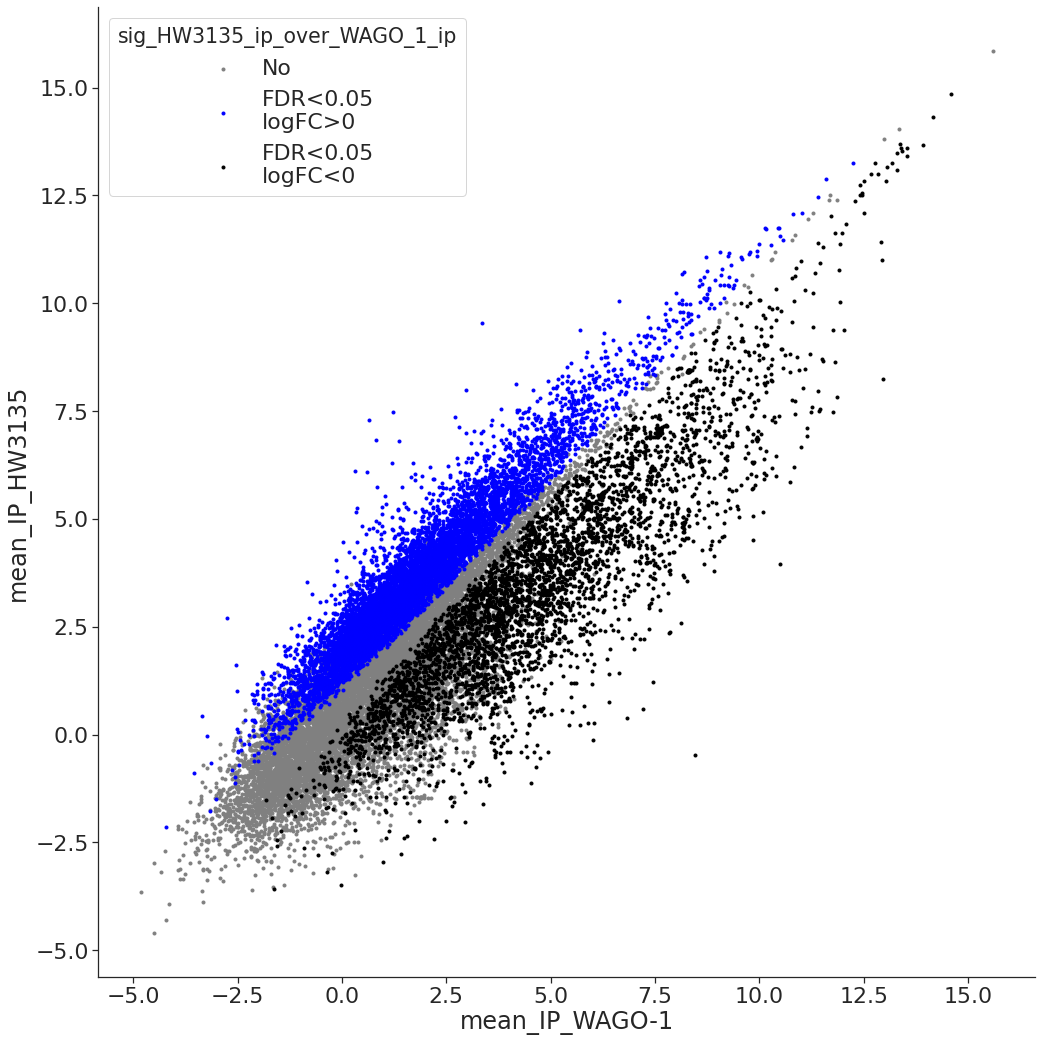

In [114]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_HW3135",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_HW3135_ip_over_WAGO_1_ip",
                      hue_order=["No", "FDR<0.05\nlogFC>0", "FDR<0.05\nlogFC<0"],
                      palette=["grey", "blue", "black"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3135__vs__mean_IP_WAGO_1__sig_HW3135_ip_over_WAGO_1_ip.pdf")

# same as before but overlay the csr-1 bound

In [115]:
# read in the HW3115 ip over input bound
df_HW3115_ip_over_HW3115_input = pd.read_csv("../../04_csr1_ip_and_wago_double_mutants/results/filter/DE_htseq_count__1_alignment_per_read__reverse__HW3115_INPUT__HW3115_IP/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                                             header=0,
                                             sep="\t")

In [116]:
tpm["sig_HW3115_ip_over_HW3115_input"] = "No"

In [117]:
tpm.loc[tpm.index.isin(list(df_HW3115_ip_over_HW3115_input[df_HW3115_ip_over_HW3115_input["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_HW3115_ip_over_HW3115_input[df_HW3115_ip_over_HW3115_input["logFC"]>0]["id"])), "sig_HW3115_ip_over_HW3115_input"] = "FDR<0.05\nlogFC>0"

In [118]:
print(tpm["sig_HW3115_ip_over_HW3115_input"].value_counts())

No                   17568
FDR<0.05\nlogFC>0     4666
Name: sig_HW3115_ip_over_HW3115_input, dtype: int64


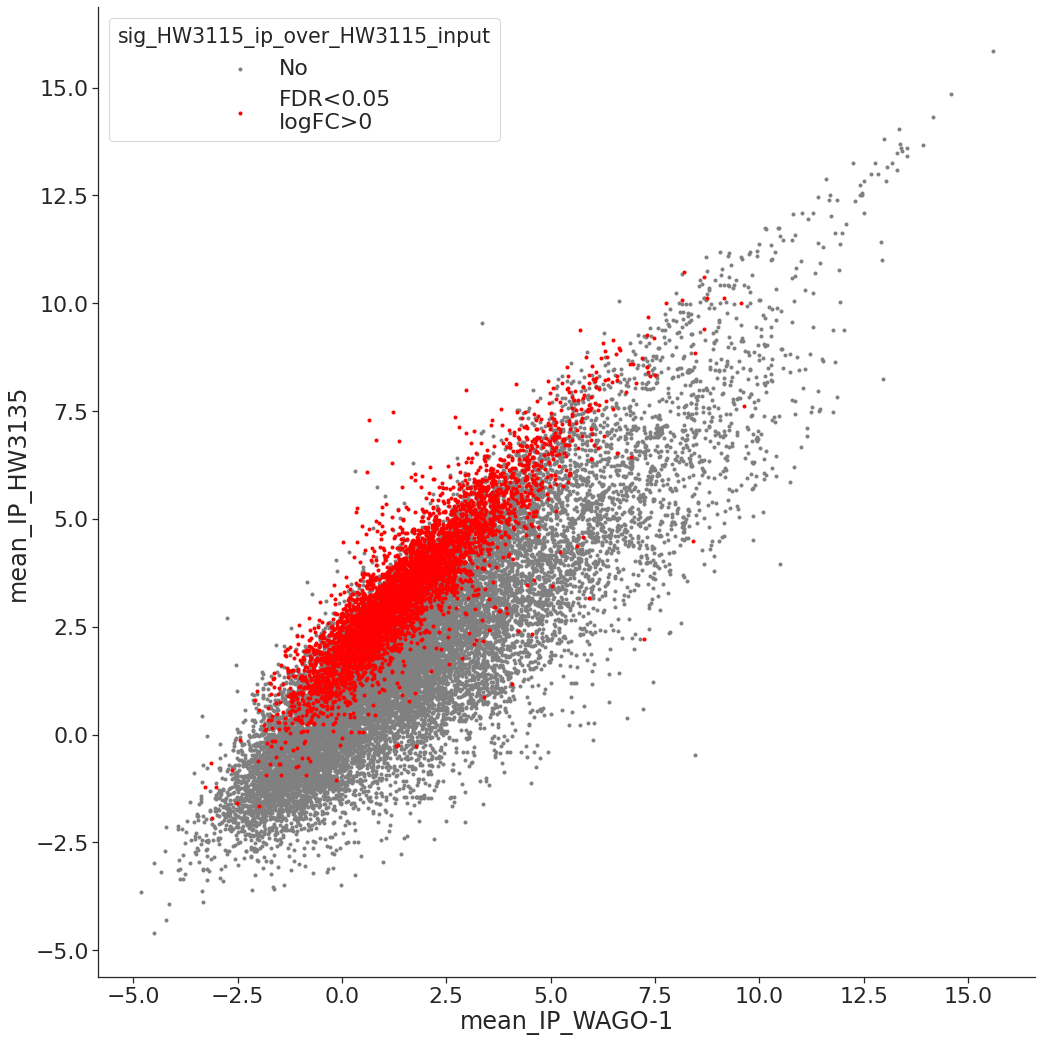

In [119]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_HW3135",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_HW3115_ip_over_HW3115_input",
                      hue_order=["No","FDR<0.05\nlogFC>0"],
                      palette=["grey", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3135__vs__mean_IP_WAGO_1__mark_sig_HW3115_ip_over_HW3115_input.pdf")

# combine the last two plots

In [120]:
tpm["Significant"] = "No"
tpm.loc[tpm["sig_HW3135_ip_over_WAGO_1_ip"] == "FDR<0.05\nlogFC>0", "Significant"] = "HW3135 IP specific"
tpm.loc[tpm["sig_HW3135_ip_over_WAGO_1_ip"] == "FDR<0.05\nlogFC<0", "Significant"] = "WAGO-1 IP specific"

In [121]:
tpm.loc[tpm["sig_HW3115_ip_over_HW3115_input"] == "FDR<0.05\nlogFC>0", "Significant"] = "csr-1 specific"

In [122]:
print(tpm["Significant"].value_counts())

No                    10277
csr-1 specific         4666
WAGO-1 IP specific     3939
HW3135 IP specific     3352
Name: Significant, dtype: int64


In [123]:
tpm.columns

Index(['HW3135_Replicate_A_IP', 'HW3135_Replicate_B_IP',
       'HW3135_Replicate_C_IP', 'IP_WAGO-1_A', 'IP_WAGO-1_B', 'IP_WAGO-1_C',
       'mean_IP_HW3135', 'mean_IP_WAGO-1', 'sig_HW3135_ip_over_WAGO_1_ip',
       'sig_HW3115_ip_over_HW3115_input', 'Significant'],
      dtype='object')

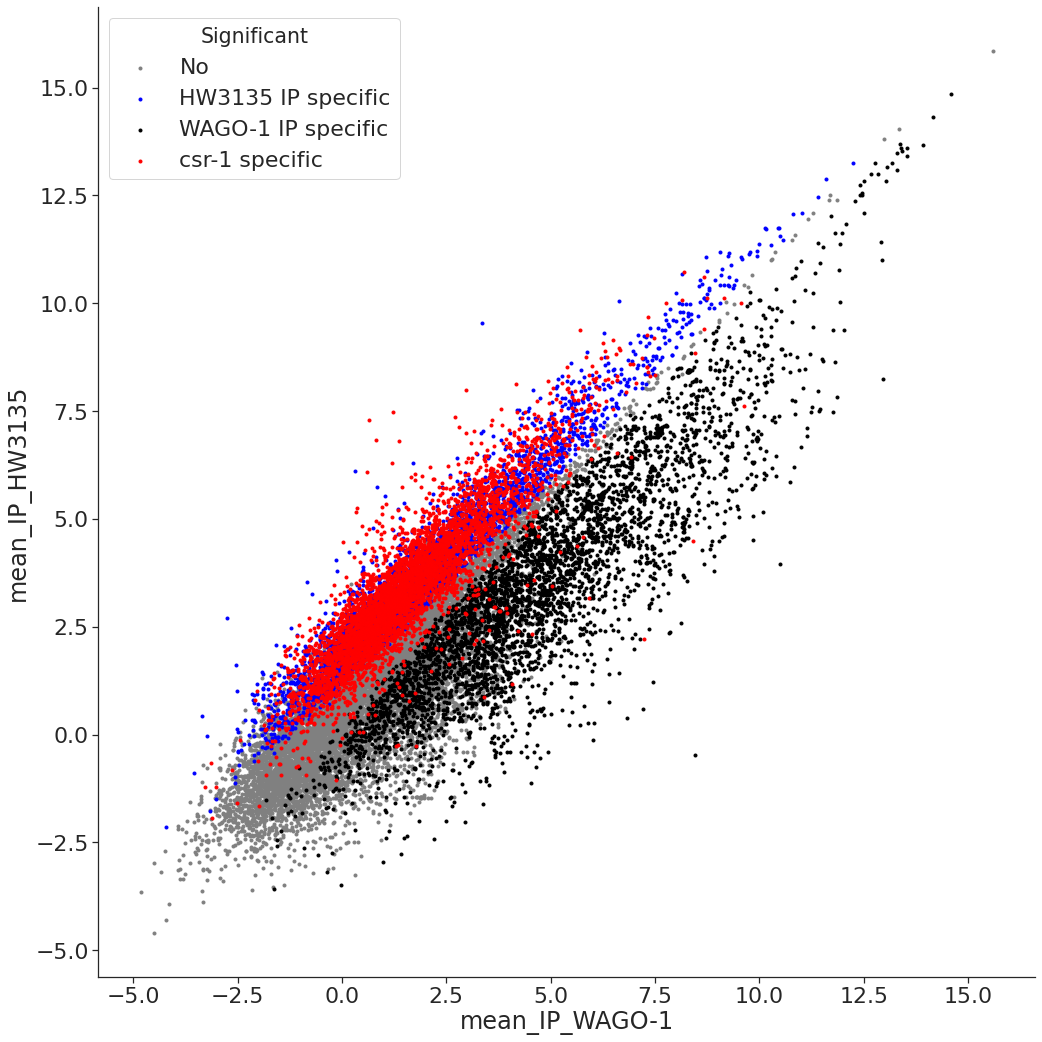

In [124]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_HW3135",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
                      hue_order=["No", "HW3135 IP specific", "WAGO-1 IP specific", "csr-1 specific"],
                      palette=["grey", "blue", "black", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)
plt.savefig(f"scatterplot__mean_IP_HW3135__vs__mean_IP_WAGO_1__mark_HW3135_IP_WAGO_1_IP_sig_HW3115_ip_over_HW3115_input.pdf")